## **Proyecto final modelo de predicción del servicio de taxis para usuarios recurrentes**

Utilizando el proyecto de tesis

1) Exploración, análisis, selección de variables y creación del
modelo sobre conjunto de train (12 puntos)

2) Creación de
pipeline (10 puntos)

3) Evaluación de
modelos usando validación cruzada (incluyendo pipeline) (5 puntos)

4) Ajuste de
hiperparámetros de los modelos seleccionados (5 puntos)

5) Creación de
Joblib

6) Despliegue del
modelo usando Sagemaker SDK. Creación de Endpoint (8 puntos)

7) Creación de un
servicio web que reciba los datos del usuario por POST desde un
formulario, solicite al endpoint de sagemaker la predicción del
modelo y devuelva la respuesta al usuario final como un HTML.(Usar
un EC2 con ip pública) (10 puntos)

---------------------------------------------------------------------

1) Exploración, análisis, selección de variables y creación del modelo sobre conjunto de train

In [12]:
#Importación de librerías
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from numpy import NaN
from datetime import date, datetime, timedelta
from os import name

In [146]:
'''
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import plot_confusion_matrix
from matplotlib.colors import ListedColormap
#from mlxtend.plotting import plot_decision_regions
#modelos
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
'''

In [4]:
NUM_OF_WEEK = 8.0
HOURS_OF_DAY = 24
DAYS_OF_WEEK = 7
FORMAT_DATE = '%Y-%m-%d'
DATE_START_TRAINIG = pd.to_datetime("2022-04-27", format=FORMAT_DATE)
#DATA_FILE = "s3://proyecto-taxis-usa/Data/SERVICIO_UNIFICADO_2022.parquet.gzip"
DATA_FILE = './../data/SERVICIO_UNIFICADO_2022.parquet.gzip'

In [5]:
#Se lee el archivo de un parquet a un dataframe
df_taxis = pd.read_parquet(DATA_FILE) 
#Se visualizan los datos
df_taxis.head(5)

,ID,IDCIUDAD,USUARIO,TELEFONOORIGEN,LATITUD,LATITUDDESTINO,LONGITUD,LONGITUDDESTINO,ESTADO,ORIGEN,FECHACOMPLETA,DIADESEMANA,HORA
0,70152580,11001,8946882.0,3186429637,4.642036,4.630580,-74.187636,-74.189880,CANCELADO,APP,2022-04-30 19:00:00,7,19
1,70152581,11001,9665930.0,3209171095,4.594340,4.604060,-74.138168,-74.141610,ABANDONADO,APP,2022-04-30 19:00:00,7,19
2,70152582,76001,9243481.0,3147558713,3.367783,NaN,-76.531083,NaN,ABANDONADO,APP,2022-04-30 19:00:01,7,19
3,70152583,11001,841805.0,3125733084,4.630927,NaN,-74.092728,NaN,ABANDONADO,CHAT_BOT_659,2022-04-30 19:00:01,7,19
4,70152584,11001,9330612.0,3043963812,4.548637,4.622711,-74.096414,-74.147018,ABANDONADO,APP,2022-04-30 19:00:01,7,19


In [9]:
#Se visualiza la estructura de la información
df_taxis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8203880 entries, 0 to 8203879
Data columns (total 13 columns):
 #   Column           Dtype  
---  ------           -----  
 0   ID               int64  
 1   IDCIUDAD         int64  
 2   USUARIO          float64
 3   TELEFONOORIGEN   object 
 4   LATITUD          float64
 5   LATITUDDESTINO   float64
 6   LONGITUD         float64
 7   LONGITUDDESTINO  float64
 8   ESTADO           object 
 9   ORIGEN           object 
 10  FECHACOMPLETA    object 
 11  DIADESEMANA      int64  
 12  HORA             int64  
dtypes: float64(5), int64(4), object(4)
memory usage: 813.7+ MB


In [7]:
#Se cuentan cuantos datos se encuentran nulos
df_taxis.isnull().sum()

ID                       0
IDCIUDAD                 0
USUARIO               1707
TELEFONOORIGEN       69322
LATITUD                  0
LATITUDDESTINO     1932690
LONGITUD                 0
LONGITUDDESTINO    1932690
ESTADO                   0
ORIGEN                   0
FECHACOMPLETA            0
DIADESEMANA              0
HORA                     0
dtype: int64

In [10]:
#Se filtran los estados importantes 
df_taxis = df_taxis[(df_taxis["ESTADO"]=="ABANDONADO") | (df_taxis["ESTADO"]=="CUMPLIDO") | (df_taxis["ESTADO"]=="CANCELADO") | (df_taxis["ESTADO"]=="FINALIZADO")]
service_date = pd.to_datetime(df_taxis['FECHACOMPLETA'], format='%Y/%m/%d %H:%M:%S')
#Se crea un nuevo campo con el mes
df_taxis['MES'] = service_date.dt.month
#Se toman los meses de enero a mayo del 2022
df_taxis = df_taxis[(df_taxis["MES"]<=5)]
#Se crea el campo año y mes
df_taxis['FECHA_MES'] = service_date.dt.strftime('%Y-%m')
#Se crea un nuevo campo con la fecha en formato YYYY/MM/DD
df_taxis['FECHA'] = service_date.dt.strftime(FORMAT_DATE)

## Visualización de datos iniciales

StopIteration: 

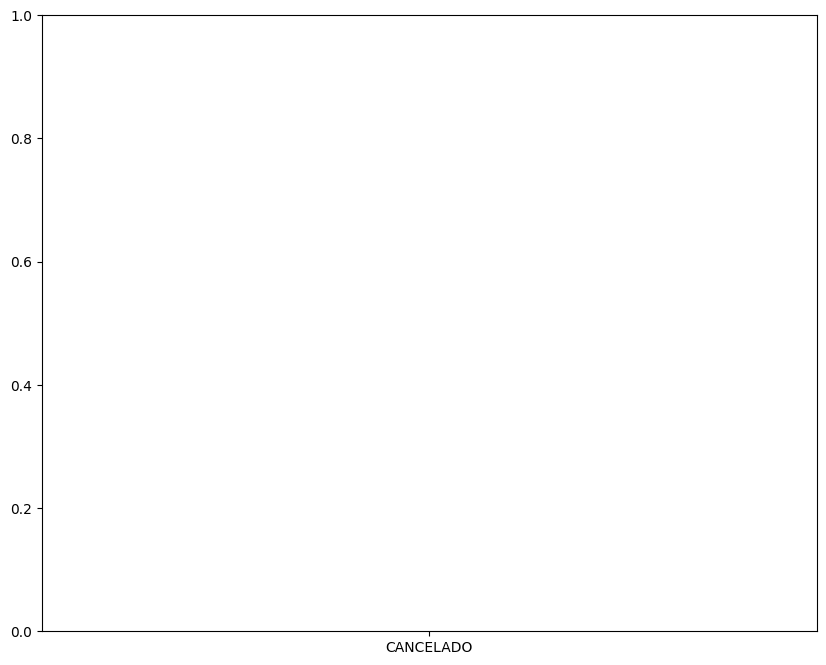

In [13]:
#Se visualiza la cantidad de servicios por estado
plt.figure(figsize=(10,8))
sns.histplot(df_taxis['ESTADO'])
plt.xticks(rotation='vertical')
plt.show()

StopIteration: 

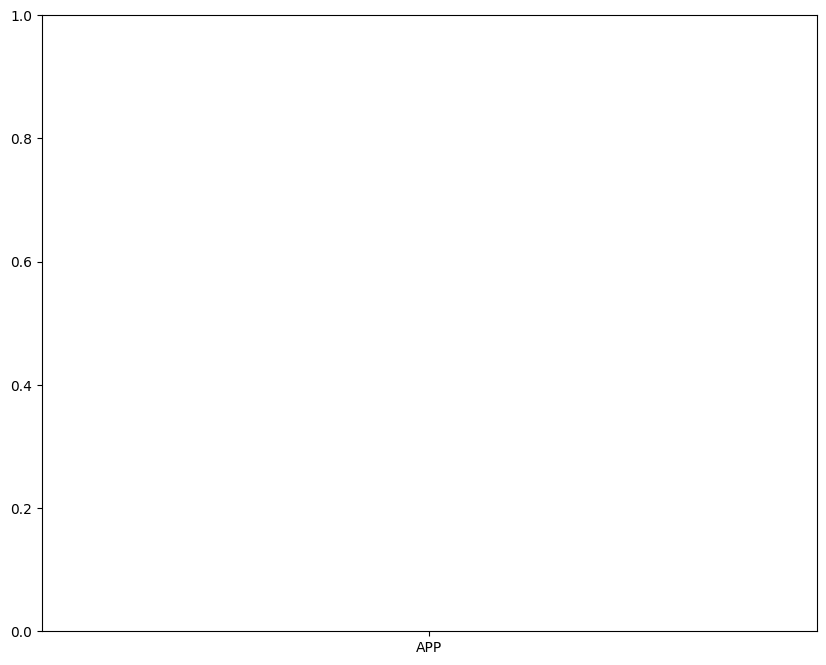

In [14]:
#Se visualiza la cantidad por origen
plt.figure(figsize=(10,8))
sns.histplot(df_taxis['ORIGEN'])
plt.xticks(rotation='vertical')
plt.show()

Se visualizan los datos del dataFrame en un histograma

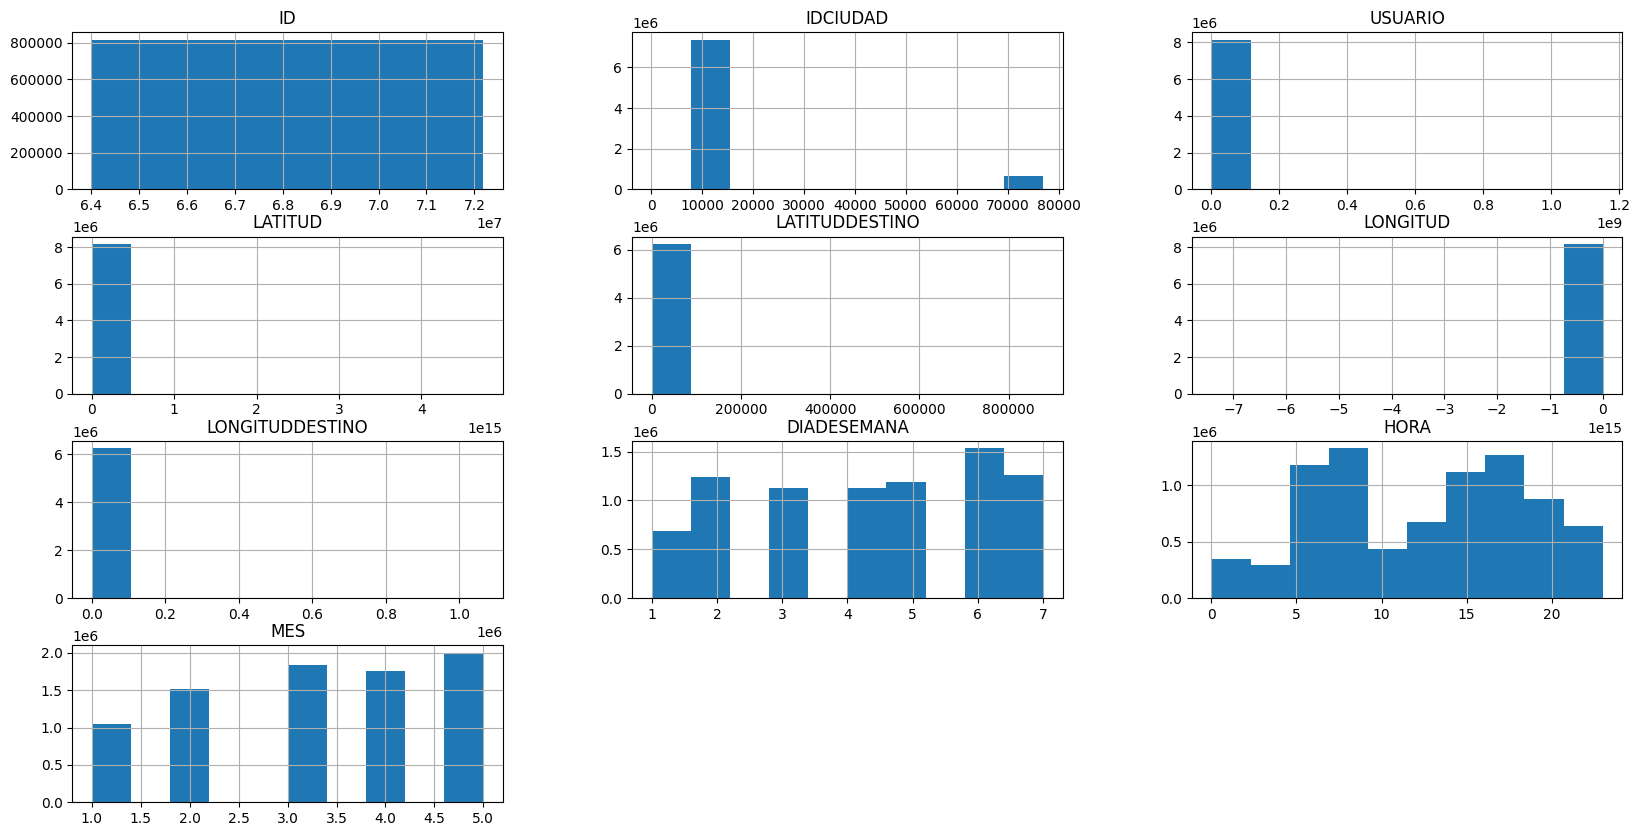

In [15]:
#Se require presentar gráfica de histograma por cada columna o datos de dataframe
df_taxis.hist(figsize=(20,10))
plt.show()

Se visualizan las corelaciones entre variables

/tmp/ipykernel_22043/1381875452.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_taxis.corr(method='pearson'),annot=True)


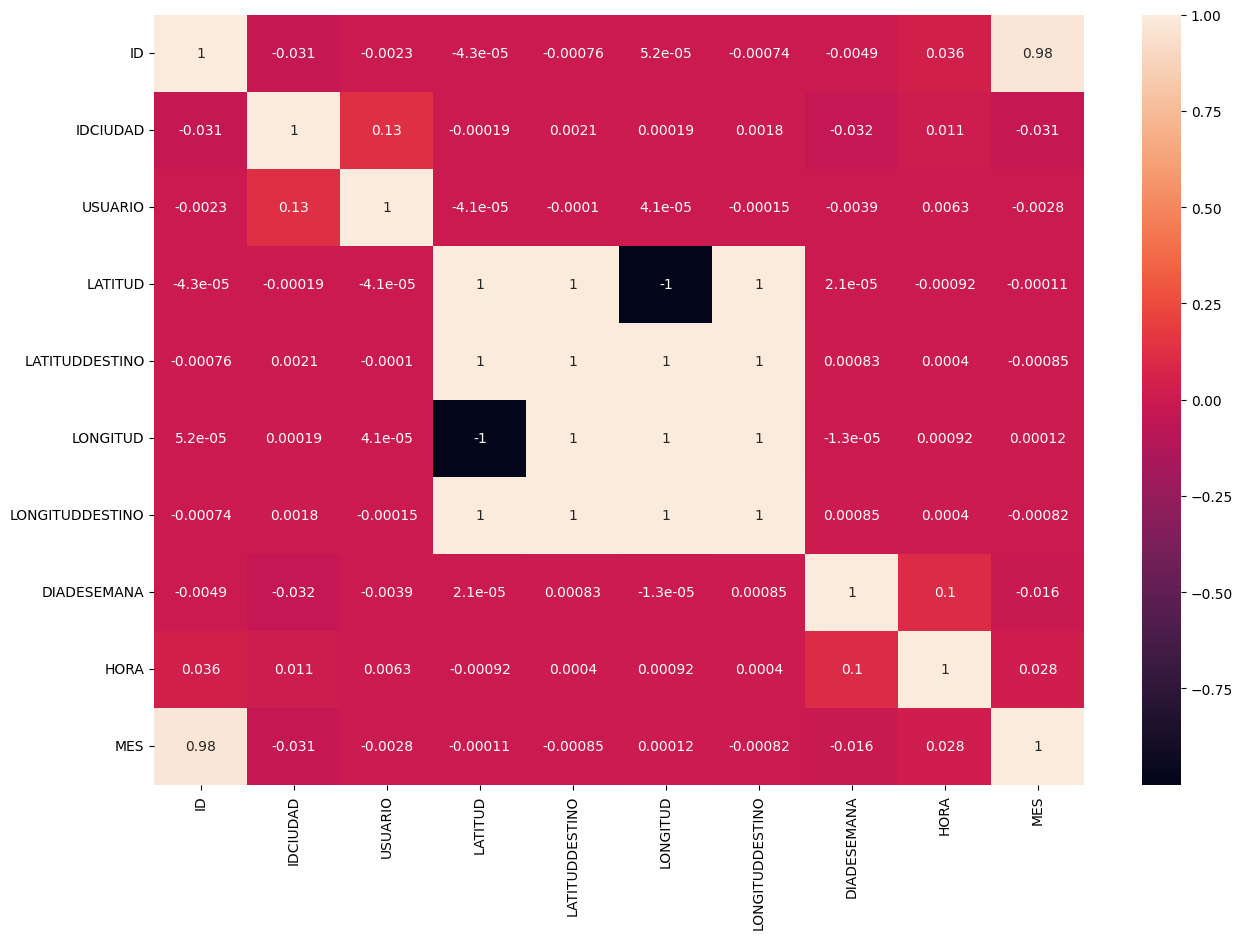

In [16]:
plt.figure(figsize=(15,10))
sns.heatmap(df_taxis.corr(method='pearson'),annot=True)
plt.show()

Se visualiza un histograma con la cantidad de servicios por estado

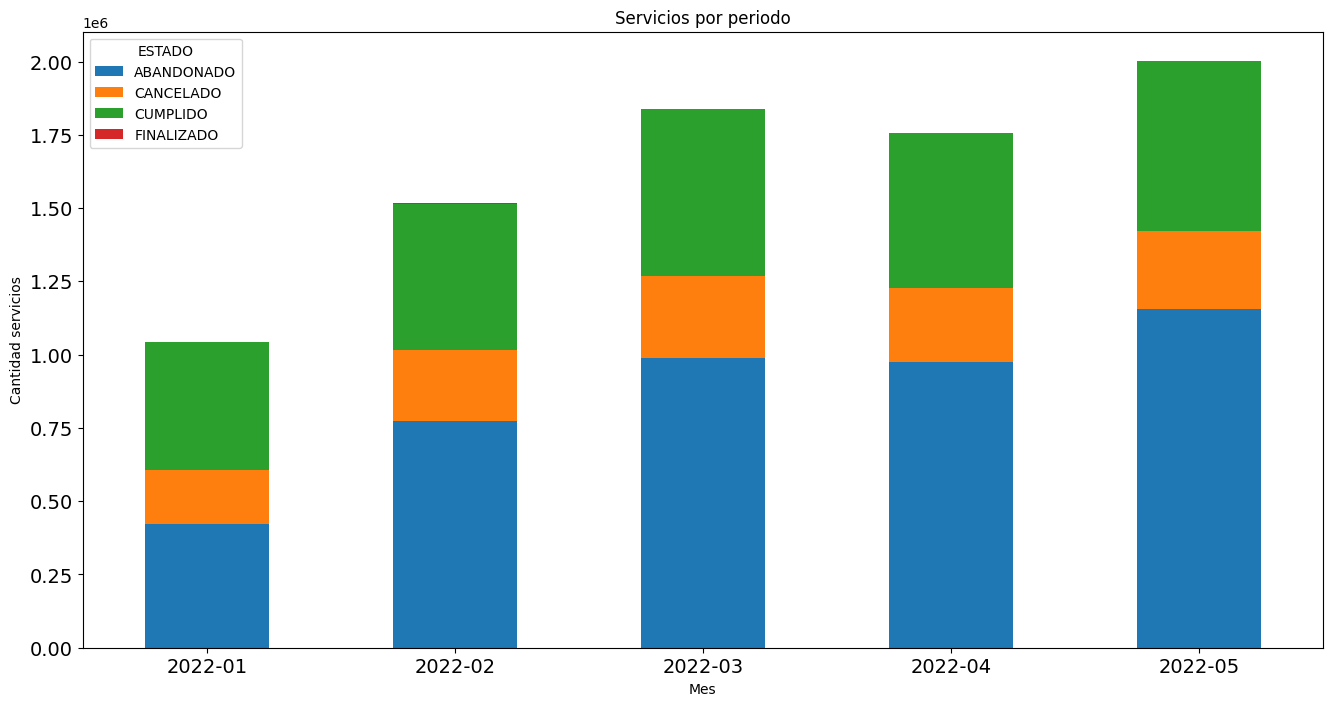

In [17]:
df_taxis.groupby(['FECHA_MES','ESTADO'])['ID'].count().unstack('ESTADO').plot(kind='bar',stacked=True, fontsize=14, xlabel="Mes", ylabel="Cantidad servicios", figsize=(16,8), title="Servicios por periodo", rot=0)
plt.show()

Se eliminan los datos que no se necesitan para predecir el modelo

In [18]:
df_taxis.head(5)

,ID,IDCIUDAD,USUARIO,TELEFONOORIGEN,LATITUD,LATITUDDESTINO,LONGITUD,LONGITUDDESTINO,ESTADO,ORIGEN,FECHACOMPLETA,DIADESEMANA,HORA,MES,FECHA_MES,FECHA
0,70152580,11001,8946882.0,3186429637,4.642036,4.630580,-74.187636,-74.189880,CANCELADO,APP,2022-04-30 19:00:00,7,19,4,2022-04,2022-04-30
1,70152581,11001,9665930.0,3209171095,4.594340,4.604060,-74.138168,-74.141610,ABANDONADO,APP,2022-04-30 19:00:00,7,19,4,2022-04,2022-04-30
2,70152582,76001,9243481.0,3147558713,3.367783,NaN,-76.531083,NaN,ABANDONADO,APP,2022-04-30 19:00:01,7,19,4,2022-04,2022-04-30
3,70152583,11001,841805.0,3125733084,4.630927,NaN,-74.092728,NaN,ABANDONADO,CHAT_BOT_659,2022-04-30 19:00:01,7,19,4,2022-04,2022-04-30
4,70152584,11001,9330612.0,3043963812,4.548637,4.622711,-74.096414,-74.147018,ABANDONADO,APP,2022-04-30 19:00:01,7,19,4,2022-04,2022-04-30


In [19]:
#Eliminamos las columan que no son útiles para el modelo
df_taxis = df_taxis.drop(columns=["IDCIUDAD","USUARIO","ID","LATITUDDESTINO","LONGITUDDESTINO","LATITUD","LONGITUD","FECHACOMPLETA","ORIGEN","ESTADO","FECHA_MES"])
#Se eliminan los valores duplicados del dataframe y se ordenan por los campos más relevangtes
df_taxis = df_taxis.drop_duplicates().sort_values(by=['TELEFONOORIGEN','FECHA','DIADESEMANA','HORA'])
#Se reindexa nuevamente el dataFrame
df_taxis = df_taxis.reset_index(drop=True)
#Se visualizan como queda el dataFrame
df_taxis.head(5)

,TELEFONOORIGEN,DIADESEMANA,HORA,MES,FECHA
0,+130047610,6,8,4,2022-04-29
1,+130055764,3,7,4,2022-04-12
2,+130055764,3,12,4,2022-04-12
3,+130153273,7,12,2,2022-02-05
4,+130153273,7,21,5,2022-05-28


Se contabilizan cuantos servicios tiene asignado un teléfono después de eliminar los duplicados

In [20]:
count_data = df_taxis.loc[:,['TELEFONOORIGEN']].value_counts()
count_data

TELEFONOORIGEN
3959999           908
3107584482        783
3187170954        698
3138647901        684
3153865158        683
                 ... 
3134075870          1
3134075868          1
3134075773          1
3134075253          1
999883673           1
Length: 640580, dtype: int64

Se visualiza la distribución de los datos

In [22]:
#Se visualizan los valores de los datos
count_data.describe().T

count    640580.000000
mean          6.293386
std          14.266877
min           1.000000
25%           1.000000
50%           2.000000
75%           5.000000
max         908.000000
dtype: float64

## Se calcula el outlayer de los datos

In [23]:
#Se calcula el quartil 25
q25 = count_data.quantile(0.25)
#Se calcula el quartil 75
q75 = count_data.quantile(0.75)
#Se calcula el rango inter quartil
iqr = q75 - q25

print(f"El porcentaje del quartil 25: {q25}")
print(f"El porcentaje del quartil 75: {q75}")
print(f"El rango inter quartil es: {iqr}")

El porcentaje del quartil 25: 1.0
El porcentaje del quartil 75: 5.0
El rango inter quartil es: 4.0


Se calcula el umbral de los valores atípicos

In [24]:
#Se calcula el umbral de los  valores atípicos
outliers_threshold = ( q75 + 3 * iqr )
print(f"El umbral de los valores atípicos es: {outliers_threshold}")
print(f"La cantidad de valores atípicos son: {sum(count_data > outliers_threshold) }")

El umbral de los valores atípicos es: 17.0
La cantidad de valores atípicos son: 50936


Eliminamos los datos que esten por debajo del umbral de los valores atípicos

In [25]:
df_cleaned = df_taxis.copy()
#Se descartan los que tienen menos del umbral de los valores atípicos
df_cleaned = df_cleaned.groupby('TELEFONOORIGEN').filter(lambda x: x['TELEFONOORIGEN'].count() > outliers_threshold)
#Se visualizan los datos agrupados por mes para determinar cuantos servicios tomó un usuario
df_cleaned.groupby(['MES','TELEFONOORIGEN'])['TELEFONOORIGEN'].count()

MES  TELEFONOORIGEN
1    0000000000        107
     12009954            6
     12013202           39
     12015158            2
     12021232            4
                      ... 
5    8959952             3
     8961419            15
     8961491             5
     8962172             8
     8987000            24
Name: TELEFONOORIGEN, Length: 231938, dtype: int64

In [26]:
#Se visualizan los valores de los datos
df_cleaned.loc[:,['TELEFONOORIGEN']].value_counts().describe()

count    50936.00000
mean        41.02246
std         33.31812
min         18.00000
25%         22.00000
50%         30.00000
75%         47.00000
max        908.00000
dtype: float64

## Visualización de datos final

StopIteration: 

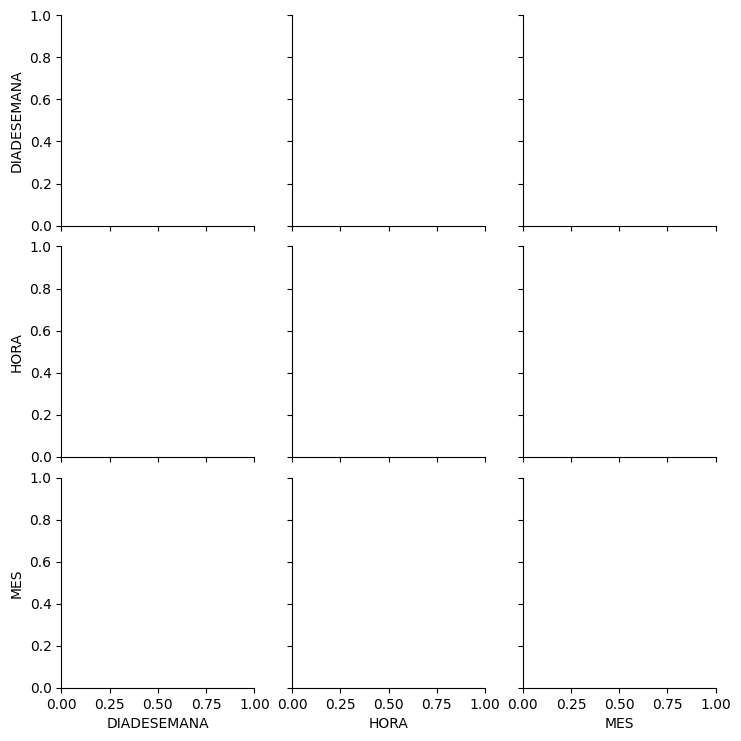

In [27]:
#Se presenta un gráfico general de los datos
sns.pairplot(df_cleaned)
plt.show()

In [30]:
#Se obtiene la matrix de correlación con los datos finales
corr_matrix = df_cleaned.corr()
corr_matrix

/tmp/ipykernel_22043/3134372602.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_cleaned.corr()


,DIADESEMANA,HORA,MES
DIADESEMANA,1.000000,0.049555,0.007493
HORA,0.049555,1.000000,0.004370
MES,0.007493,0.004370,1.000000


#se presenta gráfico  de correlación
f, ax = plt.subplots(figsize=(16, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr_matrix, annot=True, mask = mask, cmap=cmap )
plt.title('Relacion entre variables del dataframe',fontsize=20,fontname='serif')
plt.ylabel('Y', color='green', fontsize=25)
plt.xlabel('X', color='Red', fontsize=25)

In [31]:
#Se realiza un conteo de la cantidad de datos por usuario
df_cleaned.loc[:,['TELEFONOORIGEN']].value_counts()

TELEFONOORIGEN
3959999           908
3107584482        783
3187170954        698
3138647901        684
3153865158        683
                 ... 
3214610478         18
3184150583         18
3184151463         18
3214606126         18
3134438997         18
Length: 50936, dtype: int64

Se filtra un usuario con datos

In [32]:
#Se crea un nuevo dataframe con los teléfonos para entrenar cada usuario personalizado
df_phone = df_cleaned.copy()

'''
df_phone = df_phone[(df_phone["TELEFONOORIGEN"]=="3115590650") | 
(df_phone["TELEFONOORIGEN"]=="3107584482")| 
(df_phone["TELEFONOORIGEN"]=="3118082696")| 
(df_phone["TELEFONOORIGEN"]=="3152175765")]
'''
df_phone = df_phone[(df_phone["TELEFONOORIGEN"]=="3107584482")]
df_phone = df_phone.drop(columns=["TELEFONOORIGEN"])

## Se visualiza la candidad de servicios por semana durantes los meses del usuario

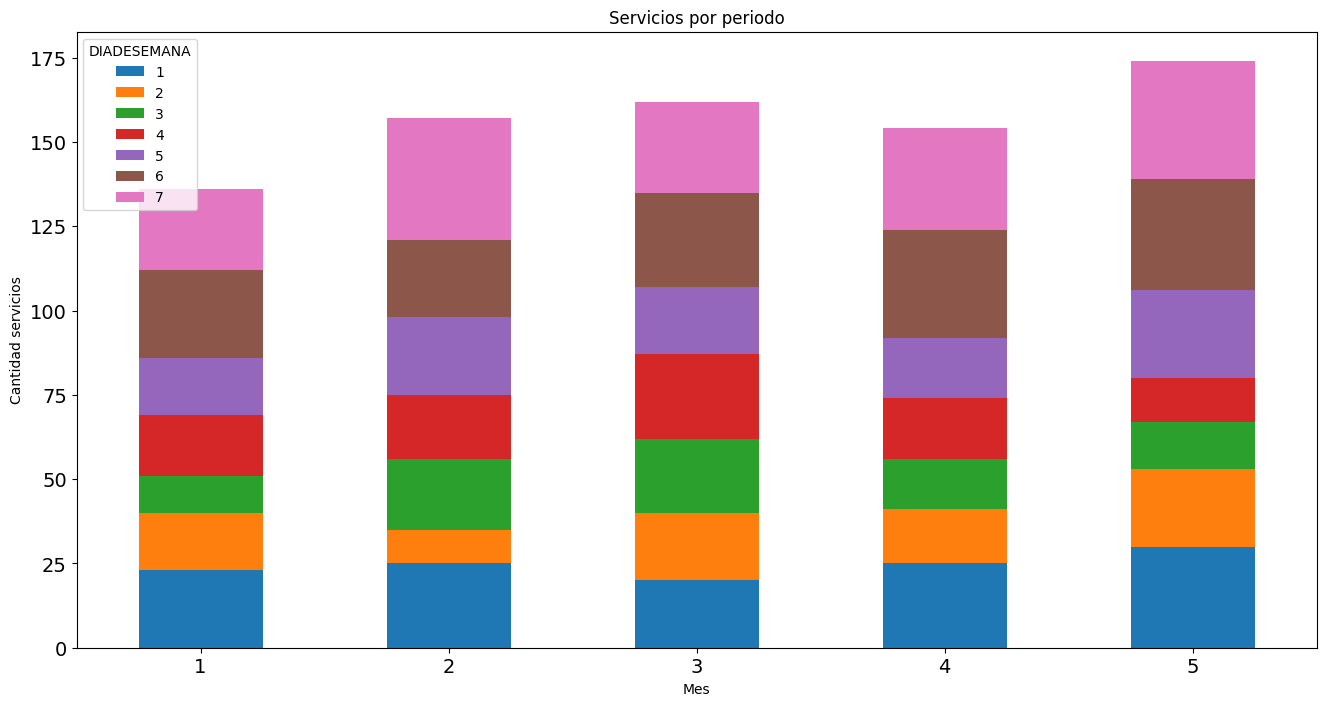

In [33]:
df_phone.groupby(['MES','DIADESEMANA'])['HORA'].count().unstack('DIADESEMANA').plot(kind='bar',stacked=True, fontsize=14, xlabel="Mes", ylabel="Cantidad servicios", figsize=(16,8), title="Servicios por periodo", rot=0)
plt.show()

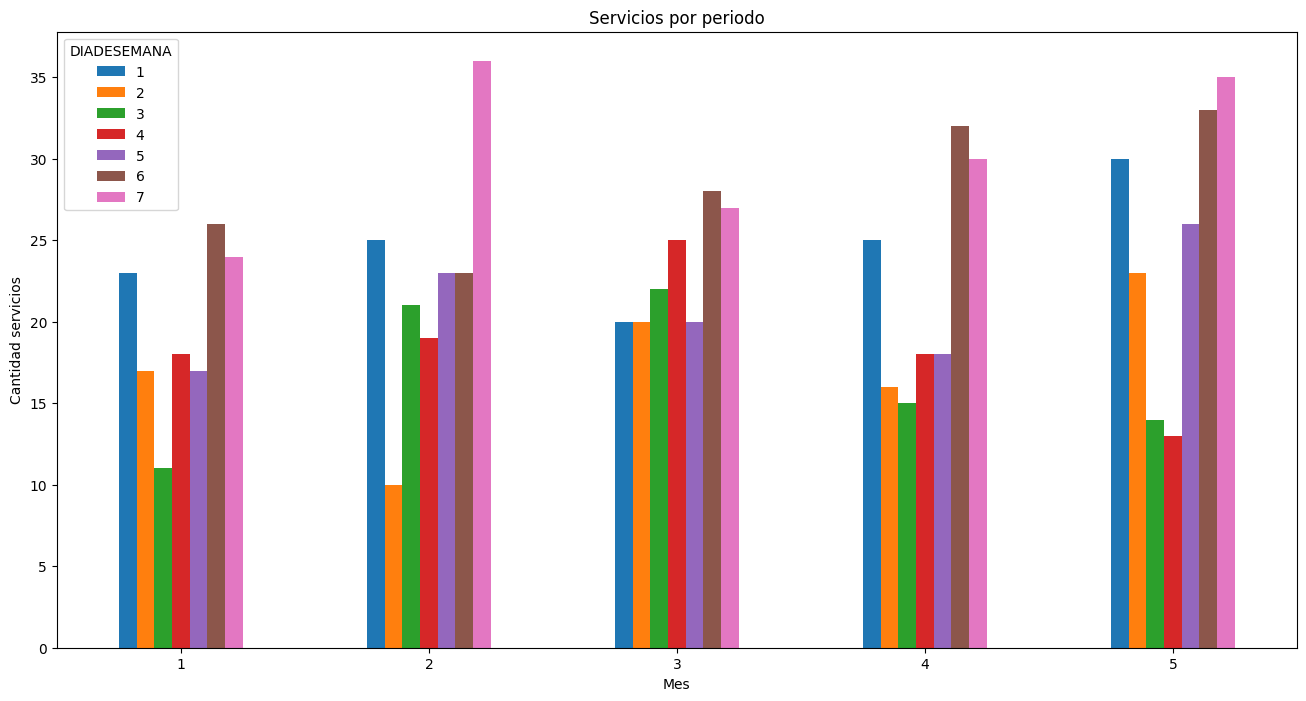

In [34]:
#Se agrupa por 'Mes' y 'Día de la semana'
df_phone.groupby(['MES','DIADESEMANA'])['HORA'].count().unstack('DIADESEMANA').plot(kind='bar', xlabel="Mes", ylabel="Cantidad servicios", figsize=(16,8), title="Servicios por periodo", rot=0)
plt.show()

Se crea la función que rellena con datos sin servicios

In [126]:
#Funcion que permite llenar los servicios tomados con 1 y los no tomados con 0
def setDataService(data, from_date, to_date):
  remaining_days = to_date.date() - from_date.date()
  service_array = []
  for i in range(remaining_days.days+1):
    last_time = from_date + timedelta(days=i)
    #if last_time.date().isoweekday() == to_date.date().isoweekday():
    for hour in range(HOURS_OF_DAY):
      #Se filtra por el mismo día de la semana, fecha y hora
      #df_service = data[(data['DIADESEMANA'] == last_time.isoweekday()) & (data['FECHA'] == last_time.date()) & (data['HORA'] == hour) ].to_numpy()
      df_service = data[(data['FECHA'].astype(str) == last_time.strftime(FORMAT_DATE)) & (data['HORA'] == hour) ].to_numpy()
      if len(df_service) > 0:
        #Se llena con valor en 1 porqué se encontró un servicio
        service_array.append(np.append(df_service, 1))
      else:
        #Se llena con valor en 0 porqué no se encontró ningún servicio
        service_array.append([last_time.isoweekday(),hour,last_time.month,last_time.date().strftime(FORMAT_DATE),0])
  return pd.DataFrame(service_array, 
             columns=np.append(np.array(data.columns.tolist()), 'SERVICIO'))

In [97]:
df_phone.head(5)

,DIADESEMANA,HORA,MES,FECHA
1198444,7,19,1,2022-01-01
1198445,1,16,1,2022-01-02
1198446,1,18,1,2022-01-02
1198447,2,12,1,2022-01-03
1198448,3,11,1,2022-01-04


In [133]:
first_date = pd.to_datetime("2022-01-01" , format=FORMAT_DATE)
last_date = pd.to_datetime("2022-05-29" , format=FORMAT_DATE)
df_phone_v2 = setDataService(df_phone, first_date, last_date)
df_phone_v2.sort_values(by=['FECHA','HORA']).head(20)

,DIADESEMANA,HORA,MES,FECHA,SERVICIO
0,6,0,1,2022-01-01,0
1,6,1,1,2022-01-01,0
2,6,2,1,2022-01-01,0
3,6,3,1,2022-01-01,0
4,6,4,1,2022-01-01,0
5,6,5,1,2022-01-01,0
6,6,6,1,2022-01-01,0
7,6,7,1,2022-01-01,0
8,6,8,1,2022-01-01,0
9,6,9,1,2022-01-01,0


In [132]:
df_phone_v2['SERVICIO'].value_counts()

0    2793
1     783
Name: SERVICIO, dtype: int64